### The goal of this notebook is to identify which Bedmap1 points are covered by other datasets

In [1]:
%matplotlib inline
import matplotlib 
import matplotlib.pyplot as plt

import importlib
import numpy as np
import os
import pathlib
import shapefile as shp  # Requires the pyshp package; I ran `pip install pyshp`


In [15]:
import detangle_bedmap_utils
importlib.reload(detangle_bedmap_utils)
from detangle_bedmap_utils import (expand_range, find_closest_bedmap,
                                   load_bedmap_ll, load_bedmap_xy, 
                                   subsample_tracks_uniform, 
                                  )

In [16]:
gl_filepath = "/Users/lindzey/Data/Quantarctica3/Glaciology/ASAID/ASAID_GroundingLine_Simplified.shp"

# If I do it this way, I can plot as points (but not lines!). This is easier than having to iterate through each segment.
sf = shp.Reader(gl_filepath)
gl_xx = []
gl_yy = []
for shape in sf.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    gl_xx.extend(x)
    gl_yy.extend(y)

In [17]:
bm1_path = "/Users/lindzey/RadarData/ANTARCTIC/BEDMAP/BEDMAP1/BEDMAP1_1966-2000_AIR_BM1.csv"
bm1_lon, bm1_lat = load_bedmap_ll(bm1_path)
bm1_xx, bm1_yy = load_bedmap_xy(bm1_path)

## AWI

* The 1994 - 1998 DML1 - DML5 surveys are all in both Bedmap1 and Bedmap2.

In [18]:
duplicate_awi_surveys = ["AWI_1994_DML1_AIR_BM2", "AWI_1995_DML2_AIR_BM2", 
                         "AWI_1996_DML3_AIR_BM2", "AWI_1997_DML4_AIR_BM2", 
                         "AWI_1998_DML5_AIR_BM2"]

In [19]:
dml_xx = {}
dml_yy = {}
dml_bm1_idxs = {}

for idx, survey in enumerate(duplicate_awi_surveys):
    dml_path = "/Users/lindzey/RadarData/ANTARCTIC/BEDMAP/BEDMAP2/{}.csv".format(survey)
    dml_xx[survey], dml_yy[survey] = load_bedmap_xy(dml_path)
    dml_bm1_idxs[survey] = find_closest_bedmap(dml_xx[survey], dml_yy[survey], bm1_xx, bm1_yy, decimation=50)    

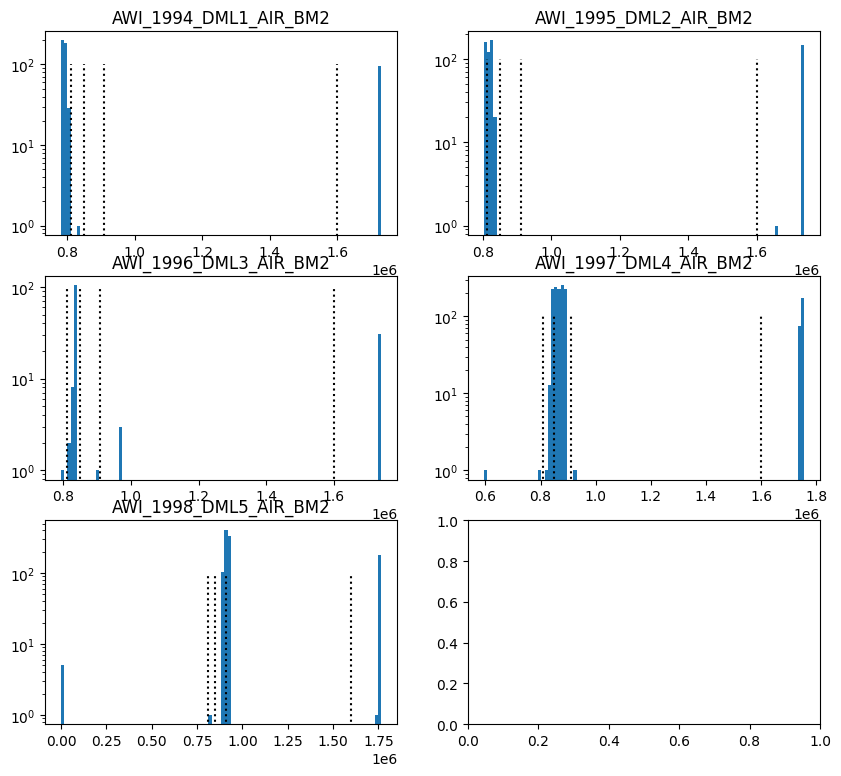

In [20]:
fig = plt.figure(figsize=(10,9))
axs = fig.subplots(3,2)

for idx, survey in enumerate(duplicate_awi_surveys):
    # Let's check the distribution of these closest points
    ii = int(np.floor(idx/2))
    jj = idx%2
    ax = axs[ii][jj]
    ax.hist(dml_bm1_idxs[survey], bins=100);
    ax.set_title(survey)
    ax.set_yscale('log')
    
    ax.vlines([8.1e5, 8.5e5, 9.1e5, 1.6e6], 0, 100, linestyle='dotted', colors='black')
    

This is messier for 1996-1998 -- rather than 2 groups, it looks like there may be additional surveys that crossed over the main one and had a few close points.

And, the histogram for the first main cluster aren't detailed enough to select the proper bounds. So, zooming in ...

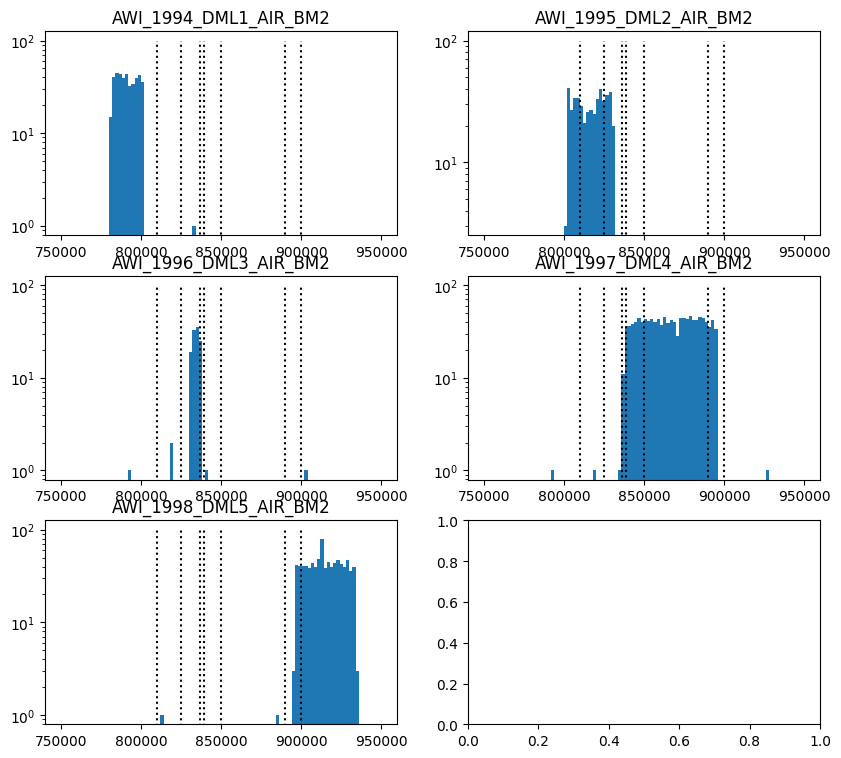

In [21]:
fig = plt.figure(figsize=(10,9))
axs = fig.subplots(3,2)

for idx, survey in enumerate(duplicate_awi_surveys):
    # Let's check the distribution of these closest points
    ii = int(np.floor(idx/2))
    jj = idx%2
    ax = axs[ii][jj]
    ax.hist(dml_bm1_idxs[survey], range=(7.5e5, 9.5e5), bins=100);
    ax.set_title(survey)
    ax.set_yscale('log')
    
    ax.vlines([8.1e5, 8.25e5, 8.365e5, 8.39e5, 8.5e5, 8.9e5, 9e5], 0, 100, linestyle='dotted', colors='black')


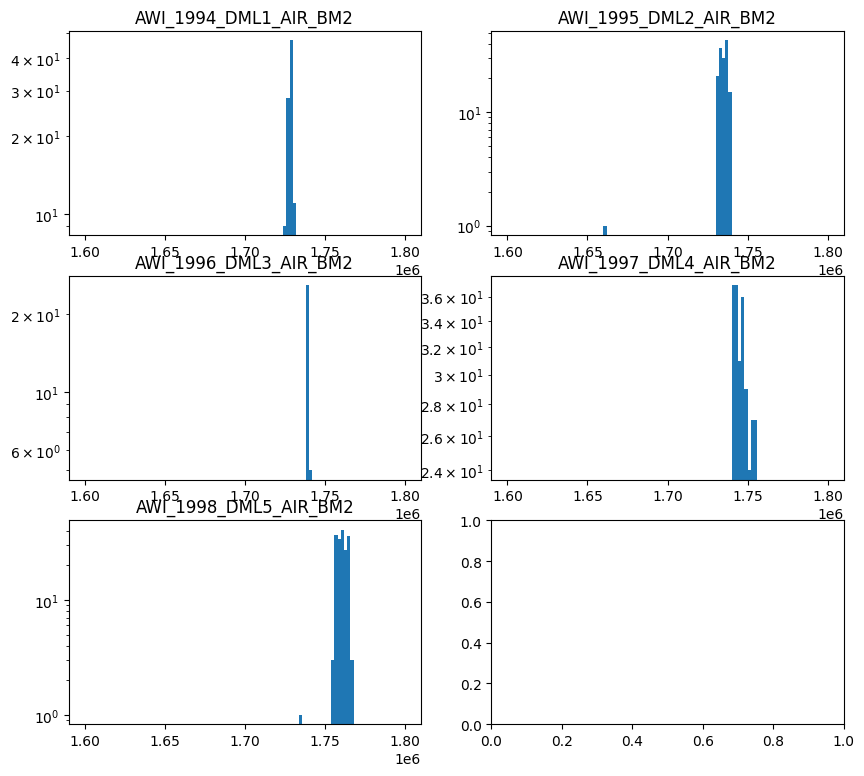

In [22]:
# when decreasing skip from 100 to 50, I needed to look even more closely at the histograms.
fig = plt.figure(figsize=(10,9))
axs = fig.subplots(3,2)

for idx, survey in enumerate(duplicate_awi_surveys):
    # Let's check the distribution of these closest points
    ii = int(np.floor(idx/2))
    jj = idx%2
    ax = axs[ii][jj]
    ax.hist(dml_bm1_idxs[survey], range=(1.6e6, 1.8e6), bins=100);
    ax.set_title(survey)
    ax.set_yscale('log')
    
    ax.vlines([], 0, 100, linestyle='dotted', colors='black')


In [23]:
# Selecting these by hand while exploring the data. 
# These bounds are very sensitive to the parameters in `find_closest_bedmap` 
# If this is a common problem in other datasets, could pick two largest clusters.
awi_survey_bounds = {}
awi_survey_bounds["AWI_1994_DML1_AIR_BM2"] = (-np.inf, 8.1e5, 1.7e6, np.inf)
awi_survey_bounds["AWI_1995_DML2_AIR_BM2"] = (-np.inf, 1e6, 1.7e6, np.inf)
awi_survey_bounds["AWI_1996_DML3_AIR_BM2"] = (8.25e5, 8.39e5, 1.7e6, np.inf)
awi_survey_bounds["AWI_1997_DML4_AIR_BM2"] = (8.365e5, 9e5, 1.7e6, np.inf)
awi_survey_bounds["AWI_1998_DML5_AIR_BM2"] = (8.9e5, 9.5e5, 1.75e6, np.inf)

In [24]:
awi_survey_ranges = {}
for idx, survey in enumerate(duplicate_awi_surveys):
    min1, max1, min2, max2 = awi_survey_bounds[survey]
    
    i1, = np.where(min1 < dml_bm1_idxs[survey])
    i2, = np.where(dml_bm1_idxs[survey] < max1)
    group1_idxs = np.intersect1d(i1, i2)
    group1_idxs = np.array(dml_bm1_idxs[survey])[group1_idxs]

    i1, = np.where(min2 < dml_bm1_idxs[survey])
    i2, = np.where(dml_bm1_idxs[survey] < max2)
    group2_idxs = np.intersect1d(i1, i2)
    group2_idxs = np.array(dml_bm1_idxs[survey])[group2_idxs]

    # See about extending the bedmap range a bit, in case we missed any
    radius = 10000
    group1_start, group1_end = expand_range(group1_idxs, dml_xx[survey], dml_yy[survey], bm1_xx, bm1_yy, radius)
    group2_start, group2_end = expand_range(group2_idxs, dml_xx[survey], dml_yy[survey], bm1_xx, bm1_yy, radius)
    
    group1_range = np.arange(group1_start, group1_end+1)  # group1_end is inclusive
    group2_range = np.arange(group2_start, group2_end+1) 
    awi_survey_ranges[survey] = (group1_range, group2_range)
    
    print("For {}, {} orig points, {} + {} = {} BM1 points"
          .format(survey, len(dml_xx[survey]), len(group1_range), len(group2_range), 
                  len(group1_range) + len(group2_range)))

For BM1 idx 781378, min_dist = 1862.53 km
For BM1 idx 801918, min_dist = 896.03 km
For BM1 idx 1725225, min_dist = 1889.70 km
For BM1 idx 1730676, min_dist = 896.30 km
For AWI_1994_DML1_AIR_BM2, 25257 orig points, 20539 + 5450 = 25989 BM1 points
For BM1 idx 801917, min_dist = 340.73 km
For BM1 idx 831197, min_dist = 53.36 km
For BM1 idx 1730675, min_dist = 349.12 km
For BM1 idx 1738607, min_dist = 51.97 km
For AWI_1995_DML2_AIR_BM2, 30600 orig points, 29279 + 7931 = 37210 BM1 points
For BM1 idx 831196, min_dist = 336.73 km
For BM1 idx 837312, min_dist = 12.72 km
For BM1 idx 1738667, min_dist = 10.12 km
For BM1 idx 1740273, min_dist = 12.05 km
For AWI_1996_DML3_AIR_BM2, 7486 orig points, 6115 + 1605 = 7720 BM1 points
For BM1 idx 837308, min_dist = 203.48 km
For BM1 idx 895839, min_dist = 151.66 km
For BM1 idx 1740271, min_dist = 203.48 km
For BM1 idx 1755842, min_dist = 150.85 km
For AWI_1997_DML4_AIR_BM2, 71905 orig points, 58530 + 15570 = 74100 BM1 points
For BM1 idx 895428, min_dist 

It's a bit odd that the BEDMAP1 dataset has more points, and more dense bed picks, than the BEDMAP2 surveys. 

The AWI_1994_DML1_AIR_BM2 survey includes 781379-801917 and 1725226-1730675
The AWI_1995_DML2_AIR_BM2 survey includes 801918-831196 and 1730676-1738606
The AWI_1996_DML3_AIR_BM2 survey includes 831197-837311 and 1738668-1740272
The AWI_1997_DML4_AIR_BM2 survey includes 837309-895838 and 1740272-1755841
The AWI_1998_DML5_AIR_BM2 survey includes 895429-934046 and 1755734-1766275


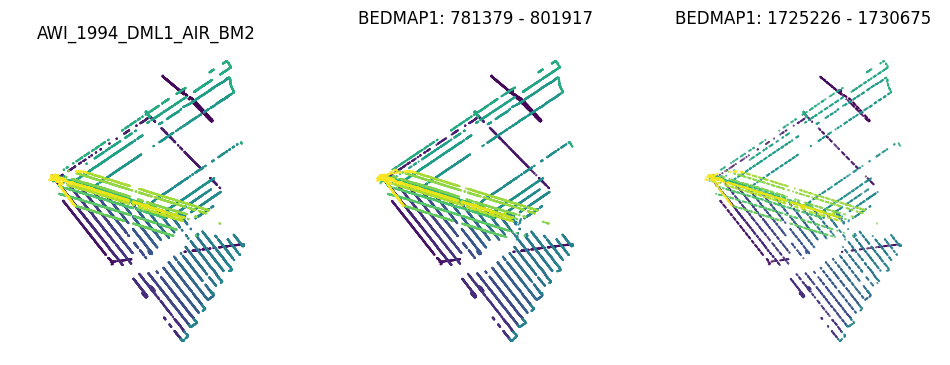

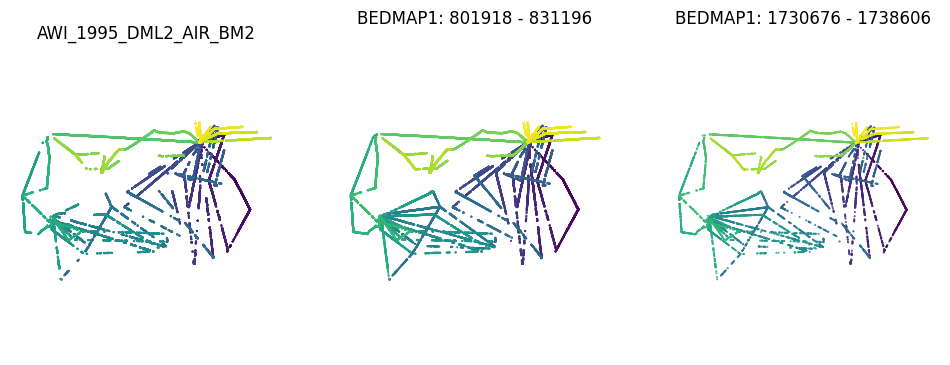

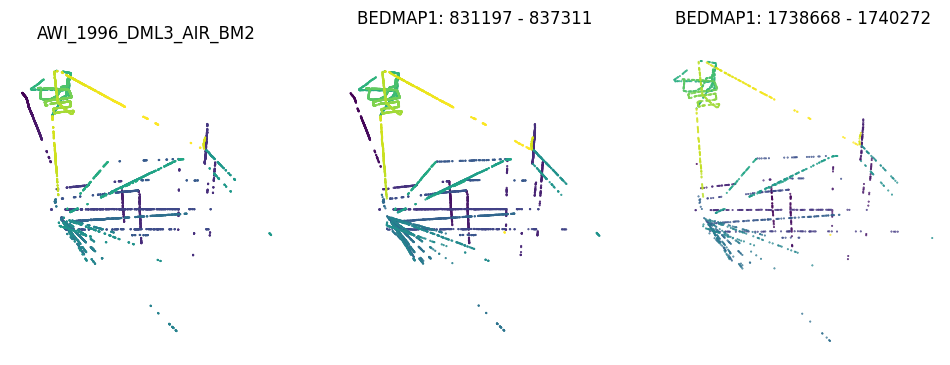

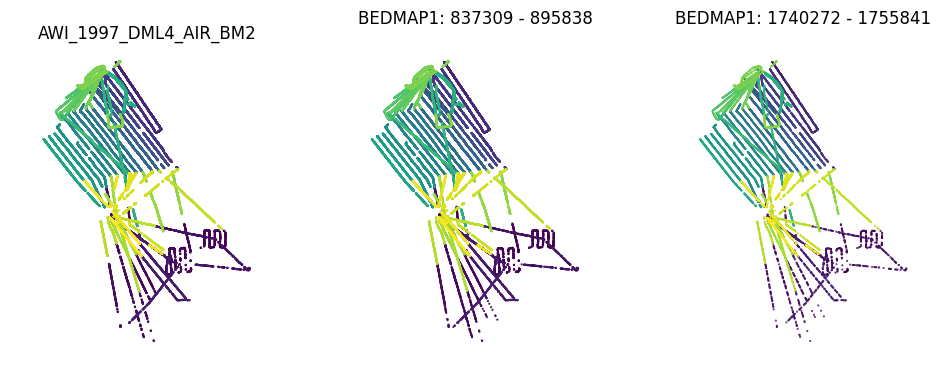

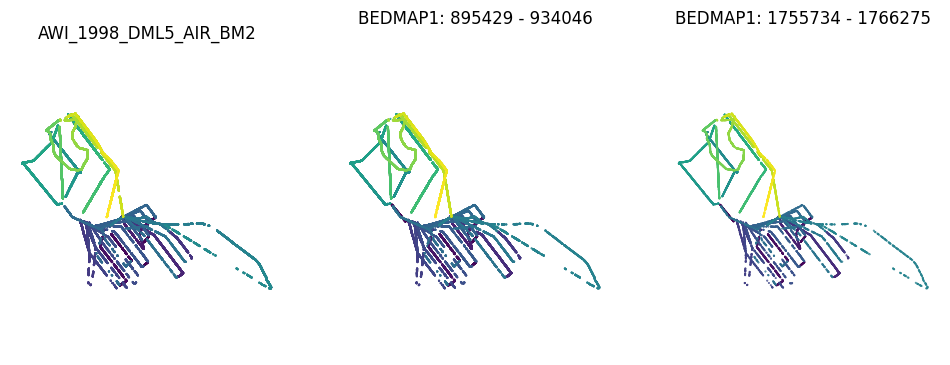

In [25]:
for survey in duplicate_awi_surveys:
    group1_range, group2_range = awi_survey_ranges[survey]
    print("The {} survey includes {}-{} and {}-{}".format(survey, np.min(group1_range), np.max(group1_range), 
                                                          np.min(group2_range), np.max(group2_range)))
    
    fig = plt.figure(figsize=(12,4))
    ax1, ax2, ax3, = fig.subplots(1,3)
    for ax in [ax1, ax2, ax3]:
        ax.axis('equal') 
        ax.axis('off')
    ax1.scatter(dml_xx[survey], dml_yy[survey], c=np.arange(0,len(dml_xx[survey])), edgecolors=None, s=0.3)
    ax1.set_title(survey)
    
    ax2.scatter(bm1_xx[group1_range], bm1_yy[group1_range], c=np.arange(0, len(group1_range)), edgecolors=None, s=0.3)
    #ax2.scatter(bm1_xx[group1_idxs], bm1_yy[group1_idxs], c=group1_idxs, edgecolors=None, s=0.3)
    ax2.set_title("BEDMAP1: {} - {}".format(group1_range[0], group1_range[-1]))
     
    ax3.scatter(bm1_xx[group2_range], bm1_yy[group2_range], c=np.arange(0, len(group2_range)), edgecolors=None, s=0.2)
    #ax3.scatter(bm1_xx[group2_idxs], bm1_yy[group2_idxs], c=group2_idxs, edgecolors=None, s=0.2)
    ax3.set_title("BEDMAP1: {} - {}".format(group2_range[0], group2_range[-1]))

From the above output:

```
The AWI_1994_DML1_AIR_BM2 survey includes 781379-801917 and 1725226-1730675
The AWI_1995_DML2_AIR_BM2 survey includes 801918-831196 and 1730676-1738606
The AWI_1996_DML3_AIR_BM2 survey includes 831197-837311 and 1738775-1740272
The AWI_1997_DML4_AIR_BM2 survey includes 837309-895838 and 1740272-1755841
The AWI_1998_DML5_AIR_BM2 survey includes 895429-934046 and 1755734-1766275
```

These are largely sequential, though there is some overlap between 3->4 and 4->5. That's fine, and makes sense if they were taking off from the same airfield.

I'm more curious about the lack of overlap from 2->3: 1_738_606 -> 1_738_775


Text(0.5, 1.0, 'AWI_1996_DML3_AIR_BM2')

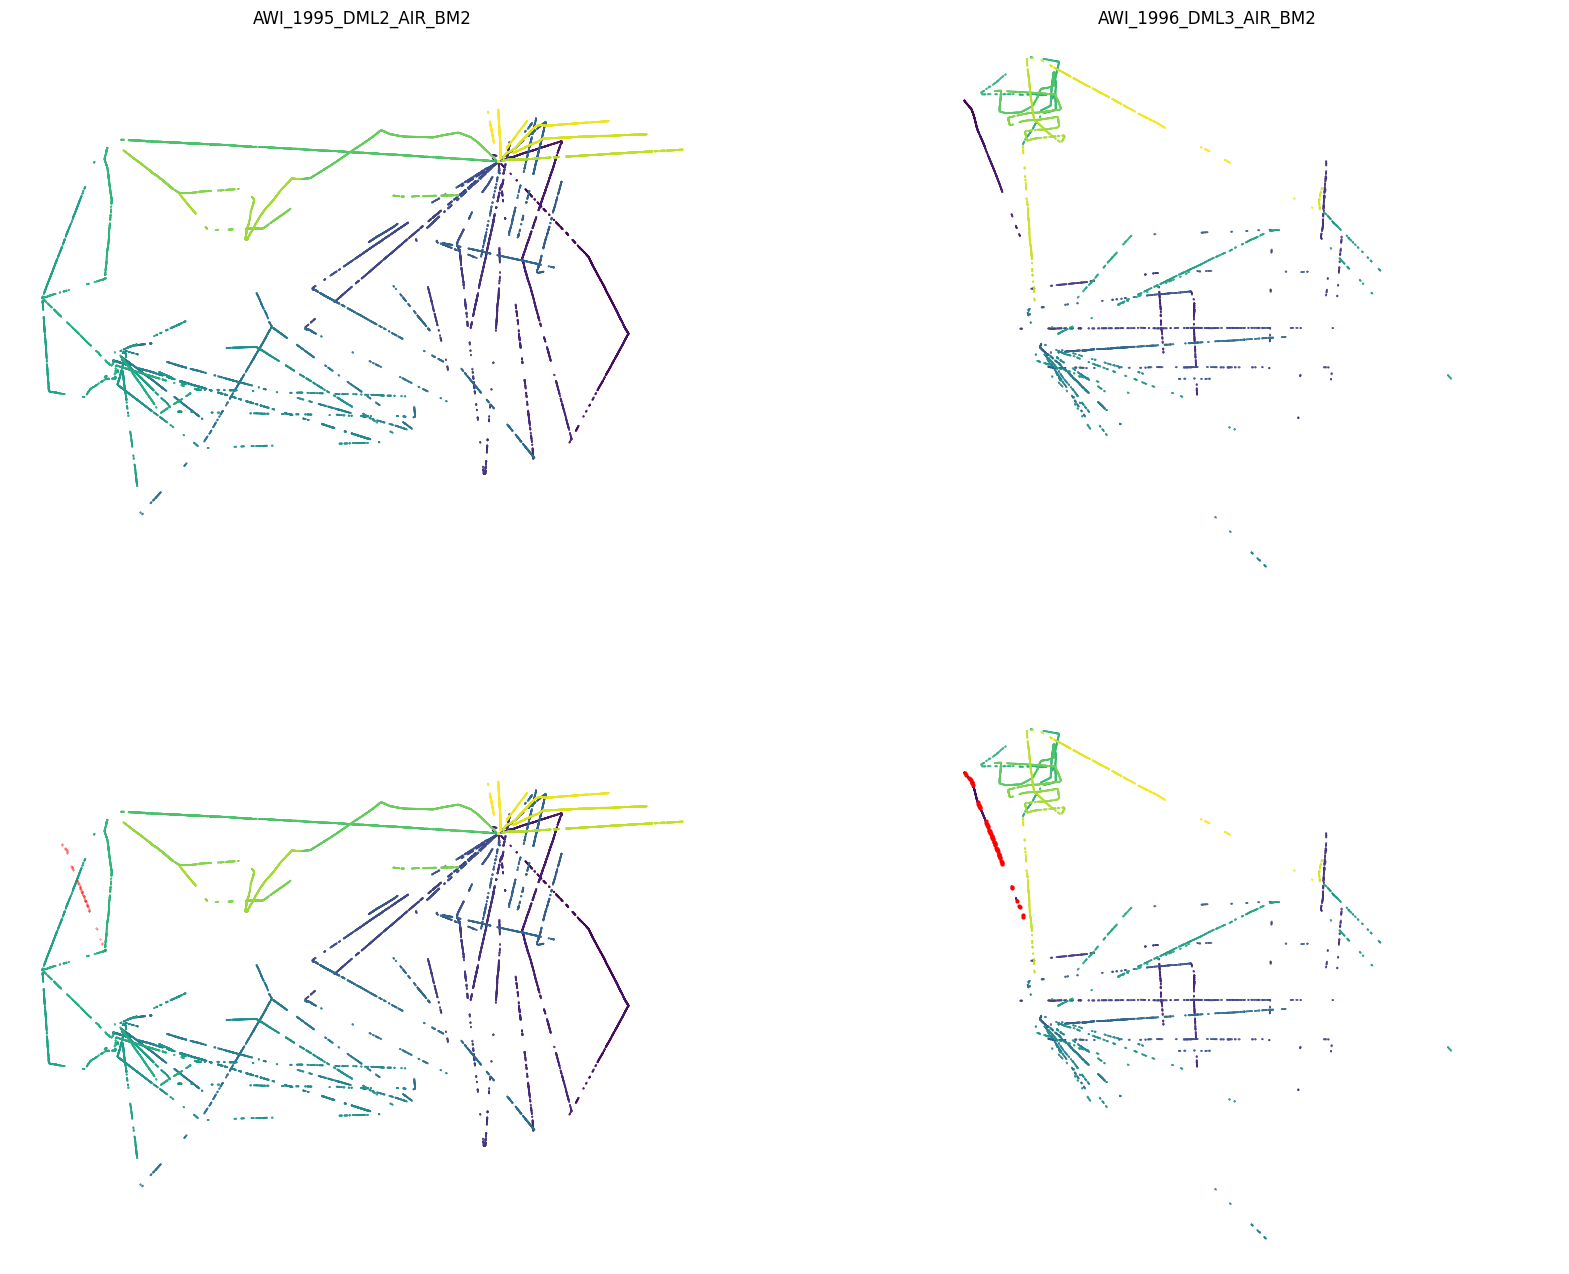

In [26]:
s2 = "AWI_1995_DML2_AIR_BM2"
s3 = "AWI_1996_DML3_AIR_BM2"
# The rest look like they're part of DML3.
missing_range = np.arange(1_738_607, 1_738_668+1)

fig = plt.figure(figsize=(20,16))
[ax1, ax2], [ax3, ax4] = fig.subplots(2,2)
for ax in [ax1, ax2, ax3, ax4]:
    ax.axis('equal') 
    ax.axis('off')
ax1.scatter(dml_xx[s2], dml_yy[s2], c=np.arange(0,len(dml_xx[s2])), edgecolors=None, s=0.1)
ax3.scatter(dml_xx[s2], dml_yy[s2], c=np.arange(0,len(dml_xx[s2])), edgecolors=None, s=0.1)
ax3.plot(bm1_xx[missing_range], bm1_yy[missing_range], 'r.', markersize=0.5)

ax1.set_title(s2)

ax2.scatter(dml_xx[s3], dml_yy[s3], c=np.arange(0,len(dml_xx[s3])), edgecolors=None, s=0.1)
ax4.scatter(dml_xx[s3], dml_yy[s3], c=np.arange(0,len(dml_xx[s3])), edgecolors=None, s=0.1)
ax4.plot(bm1_xx[missing_range], bm1_yy[missing_range], 'r.', markersize=4)
ax2.set_title(s3)



Those points look like they should've been part of DML3, but there was a slight discrepancy between points submitted to BEDMAP1 and BEDMAP2. I'll manually update the bounds to include those.

Final bounds:
```
The AWI_1994_DML1_AIR_BM2 survey includes 781379-801917 and 1725226-1730675
The AWI_1995_DML2_AIR_BM2 survey includes 801918-831196 and 1730676-1738606
The AWI_1996_DML3_AIR_BM2 survey includes 831197-837311 and 1738607-1740272
The AWI_1997_DML4_AIR_BM2 survey includes 837309-895838 and 1740272-1755841
The AWI_1998_DML5_AIR_BM2 survey includes 895429-934046 and 1755734-1766275
```